# Set up + Initial Data Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install cartopy
!pip install cftime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cftime
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.1 MB/s eta 0:00:00


Data is accessed [here](https://www.cesm.ucar.edu/community-projects/lens2)

I downloaded the data locally so I wouldn't need to pull from the server every time. The data is too large to put into Github. Here's is a google drive link to it:
https://drive.google.com/drive/folders/1R9ZXaIRMBmohVfNaAeBQJYGgiUgyojIq?usp=sharing

In [2]:
# Load the dataset without decoding times
fn = '/content/drive/MyDrive/LargeEnsemble/LargeEnsemble/ENSO_SST/ENSO_SST/ENSO_Project_SST_r10i1181p1f1.nc'
enso = xr.open_dataset(fn, decode_times=False)

# Extract the time variable
time_var = enso['time']

# Convert the numeric time values to datetime objects
time_units = time_var.attrs['units']
calendar = time_var.attrs.get('calendar', 'noleap')
time_dates = cftime.num2date(time_var[:], units=time_units, calendar=calendar)

# Convert cftime.DatetimeNoLeap to pandas Timestamp
def cftime_to_datetime(cftime_obj):
    return pd.Timestamp(cftime_obj.isoformat())

# Apply the conversion
time_dates_standard = [cftime_to_datetime(t) for t in time_dates]
enso['time'] = ('time', time_dates_standard)
enso = enso.sel(time=slice('1959-01-01','2021-12-01'))

enso['SST']=(enso['SST']-273.15)  # Use the formula to get from C to F.

# Add some attributes as name:value pairs.
enso['SST'].attrs['long_name']='2m temperature'
enso['SST'].attrs['units']='Fahrenheit'
enso['SST'].attrs['formula']='(K-273.15) x 1.8 + 32'

# Slice to the Pacific Ocean
enso_po = enso.sel(lon=slice(130, 290), lat=slice(-30, 30))

# Calculate climatology
enso_clim = enso_po.groupby("time.month").mean('time')

# Calculate anomaly
enso_anoms = enso_po.groupby("time.month")-enso_clim

# Calculate area weighted mean for pacific ocean
weights = np.cos(np.deg2rad(enso_po.lat)); weights.name = "weights"
SSTa_global_mean = enso_anoms['SST'].weighted(weights).mean(dim=['lat','lon'])

# Global anomaly mean smoothed over many months
SSTa_global_mean_runningMean=SSTa_global_mean.rolling(time=12*5,center=True).mean()

# Detrend data
enso_detrended=(SSTa_global_mean-SSTa_global_mean_runningMean)

# Calcuate oceanic nino index (ONI) = 3 month rolling mean of SST anomaly
NINO34 = enso_anoms['SST'].weighted(weights).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() # rolling mean over 3 months

Plot Time series of ONI and Detrended sea surface temperature anomalies in the pacific ocean.

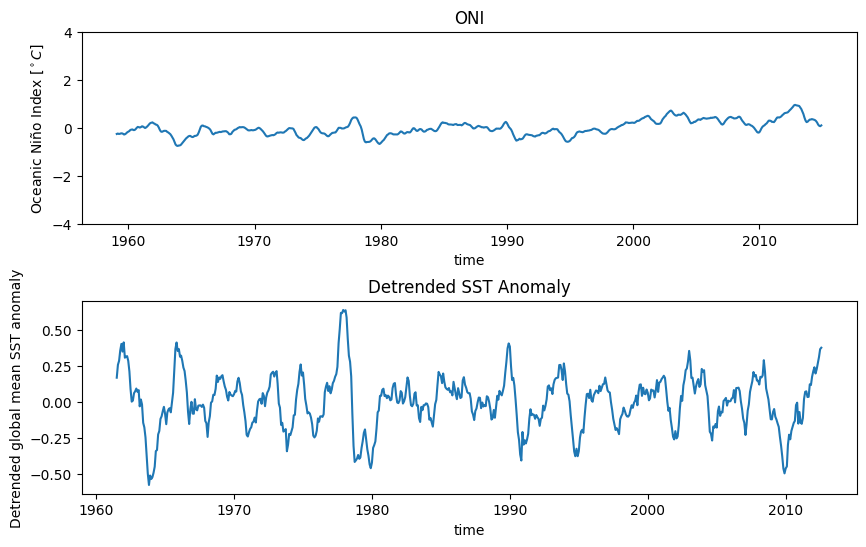

In [3]:
plt.figure(figsize=(10,6))

ax=plt.subplot(2,1,1)
ONI.plot(ax=ax)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');plt.ylim((-4,4))
plt.title('ONI')
ax=plt.subplot(2,1,2)
enso_detrended.plot(ax=ax)
plt.ylabel("Detrended global mean SST anomaly")
plt.title('Detrended SST Anomaly')
plt.subplots_adjust(hspace=0.4)

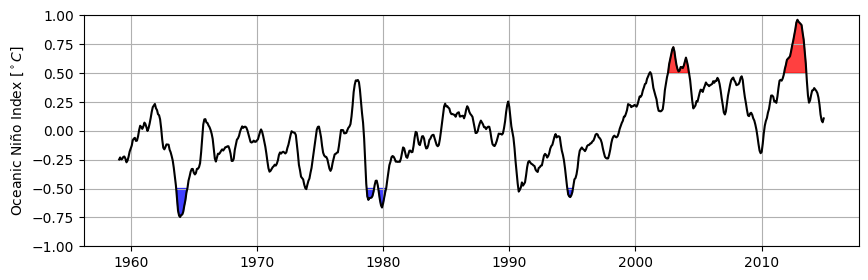

In [4]:
plt.figure(figsize=(10,3))
ax=plt.gca()
plt.plot(ONI.time, ONI,'k')
ax.fill_between(ONI.time.data, 0.5, ONI, ONI> 0.5, color='red', alpha=.75)
ax.fill_between(ONI.time.data, -0.5, ONI, ONI< -0.5, color='blue',  alpha=.75)
plt.ylim((-1,1))
plt.grid(visible=True)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');

Text(0, 0.5, 'Time')

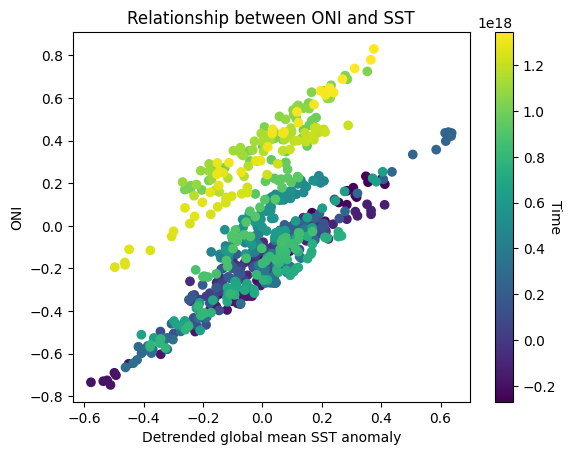

In [5]:
plt.scatter(enso_detrended,ONI,c=ONI.time)
plt.xlabel('Detrended global mean SST anomaly')
plt.ylabel("ONI")
plt.title("Relationship between ONI and SST")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time', rotation=270)


# Get X and Y

In [6]:
### Function for enso climatology data

def get_climatology_data(fld, run):
    fn = f'/content/drive/MyDrive/LargeEnsemble/LargeEnsemble/ENSO_{fld}/ENSO_{fld}/ENSO_Project_{fld}_{run}p1f1.nc'
    enso = xr.open_dataset(fn, decode_times=False)

    time_var = enso['time']
    time_units = time_var.attrs['units']
    calendar = time_var.attrs.get('calendar', 'noleap')
    time_dates = cftime.num2date(time_var[:], units=time_units, calendar=calendar)

    time_dates_standard = [cftime_to_datetime(t) for t in time_dates]
    enso['time'] = ('time', time_dates_standard)

    enso = enso.sel(time=slice('1959-01-01','2021-12-01'))

    enso_po = enso.sel(lon=slice(120, 290), lat=slice(-30, 30))

    enso_clim = enso_po.groupby("time.month").mean('time')
    enso_anoms = enso_po.groupby("time.month")-enso_clim

    weights = np.cos(np.deg2rad(enso_po.lat)); weights.name = "weights"
    global_mean = enso_anoms[fld].weighted(weights).mean(dim=['lat','lon'])
    global_mean_runningMean=global_mean.rolling(time=12*5,center=True).mean()
    enso_detrended=(global_mean-global_mean_runningMean)


    return enso, enso_po, enso_clim, enso_anoms, enso_detrended

# Get all climatology data and store in dictionary all_enso
# all_enso[run][fld]['enso_po'] to get data for example

runs = ['r10i1181', 'r9i1161', 'r8i1141', 'r7i1121', 'r6i1101', 'r5i1081', 'r4i1061', 'r3i1041', 'r2i1021', 'r1i1001']
flds = ['SST', 'PSL', 'U10', 'PRECT']
all_enso = {}

for run in runs:
    all_enso[run] = {}
    for fld in flds:
        enso, enso_po, enso_clim, enso_anoms, enso_detrended = get_climatology_data (fld, run)
        all_enso[run][fld] = {'enso': enso, 'enso_po': enso_po,'enso_clim': enso_clim,'enso_anoms': enso_anoms, 'enso_detrended':enso_detrended}

In [54]:
all_enso['r10i1181']['SST']

{'enso': <xarray.Dataset> Size: 17MB
 Dimensions:    (lat: 64, lon: 96, time: 673)
 Coordinates:
   * lat        (lat) float64 512B -89.06 -86.23 -83.4 ... 83.4 86.23 89.06
   * lon        (lon) float64 768B 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
   * time       (time) datetime64[ns] 5kB 1959-01-01 1959-02-01 ... 2015-01-01
     member_id  <U12 48B ...
 Data variables:
     SST        (time, lat, lon) float32 17MB ...,
 'enso_po': <xarray.Dataset> Size: 3MB
 Dimensions:    (lat: 22, lon: 46, time: 673)
 Coordinates:
   * lat        (lat) float64 176B -29.69 -26.86 -24.03 ... 24.03 26.86 29.69
   * lon        (lon) float64 368B 121.2 125.0 128.8 132.5 ... 282.5 286.2 290.0
   * time       (time) datetime64[ns] 5kB 1959-01-01 1959-02-01 ... 2015-01-01
     member_id  <U12 48B ...
 Data variables:
     SST        (time, lat, lon) float32 3MB ...,
 'enso_clim': <xarray.Dataset> Size: 50kB
 Dimensions:    (month: 12, lat: 22, lon: 46)
 Coordinates:
   * lat        (lat) float64 176B

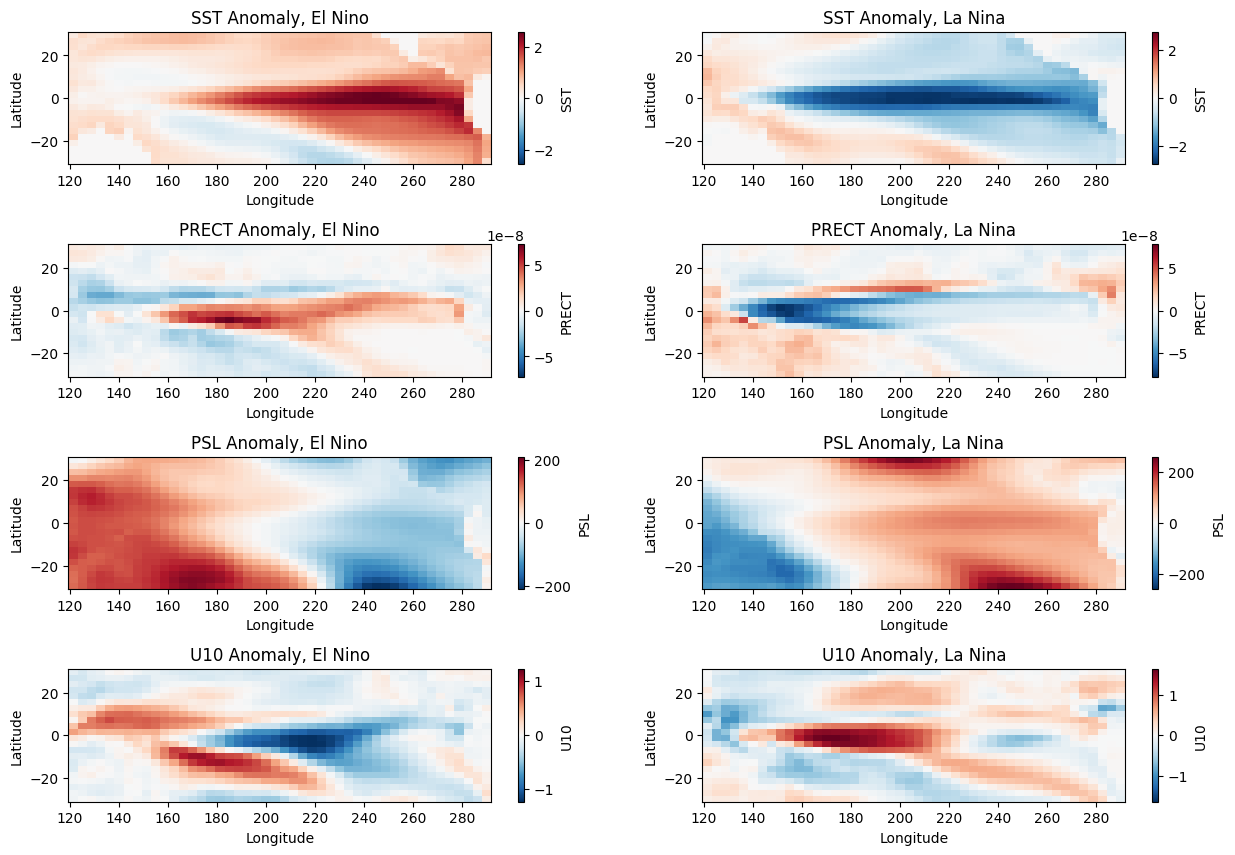

In [7]:
el_nino = ONI > 0.5
la_nina = ONI < -0.5

sst_anom_el_nino = all_enso['r10i1181']['SST']['enso_anoms'].SST[el_nino].mean('time')
sst_anom_la_nina = all_enso['r10i1181']['SST']['enso_anoms'].SST[la_nina].mean('time')

pr_anom_el_nino = all_enso['r10i1181']['PRECT']['enso_anoms'].PRECT[el_nino].mean('time')
pr_anom_la_nina = all_enso['r10i1181']['PRECT']['enso_anoms'].PRECT[la_nina].mean('time')

psl_anom_el_nino = all_enso['r10i1181']['PSL']['enso_anoms'].PSL[el_nino].mean('time')
psl_anom_la_nina = all_enso['r10i1181']['PSL']['enso_anoms'].PSL[la_nina].mean('time')

u10_anom_el_nino = all_enso['r10i1181']['U10']['enso_anoms'].U10[el_nino].mean('time')
u10_anom_la_nina = all_enso['r10i1181']['U10']['enso_anoms'].U10[la_nina].mean('time')


fig, ax = plt.subplots(4, 2,figsize=(15, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.6)

sst_anom_el_nino.plot(ax = ax[0, 0])
ax[0, 0].set_xlabel('Longitude')
ax[0, 0].set_ylabel('Latitude')
ax[0, 0].set_title('SST Anomaly, El Nino')

sst_anom_la_nina.plot(ax = ax[0, 1])
ax[0, 1].set_xlabel('Longitude')
ax[0, 1].set_ylabel('Latitude')
ax[0, 1].set_title('SST Anomaly, La Nina')

pr_anom_el_nino.plot(ax = ax[1, 0])
ax[1, 0].set_xlabel('Longitude')
ax[1, 0].set_ylabel('Latitude')
ax[1, 0].set_title('PRECT Anomaly, El Nino')

pr_anom_la_nina.plot(ax = ax[1, 1])
ax[1, 1].set_xlabel('Longitude')
ax[1, 1].set_ylabel('Latitude')
ax[1, 1].set_title('PRECT Anomaly, La Nina')

psl_anom_el_nino.plot(ax = ax[2, 0])
ax[2, 0].set_xlabel('Longitude')
ax[2, 0].set_ylabel('Latitude')
ax[2, 0].set_title('PSL Anomaly, El Nino')

psl_anom_la_nina.plot(ax = ax[2, 1])
ax[2, 1].set_xlabel('Longitude')
ax[2, 1].set_ylabel('Latitude')
ax[2, 1].set_title('PSL Anomaly, La Nina')

u10_anom_el_nino.plot(ax = ax[3, 0])
ax[3, 0].set_xlabel('Longitude')
ax[3, 0].set_ylabel('Latitude')
ax[3, 0].set_title('U10 Anomaly, El Nino')

u10_anom_la_nina.plot(ax = ax[3, 1])
ax[3, 1].set_xlabel('Longitude')
ax[3, 1].set_ylabel('Latitude')
ax[3, 1].set_title('U10 Anomaly, La Nina')

plt.savefig('enso_climatology.jpeg', dpi=500)

## Prepare Input and Output

### Input: Sea surface temperature

In [8]:
# make function for getting testing data for CNN - combine 9 of the ensemble members

def get_testing_data(fld):
  runs = ['r1i1001', 'r2i1021', 'r3i1041', 'r4i1061', 'r5i1081', 'r6i1101', 'r7i1121', 'r8i1141', 'r9i1161', 'r10i1181']

  arrays = []

  for i, run in enumerate(runs):
    array = all_enso[run][fld]['enso_anoms']
    array = array.expand_dims('ensemble_member')
    array['ensemble_member'] = [f'm{i+1}']
    arrays.append(array)

# Concatenate all the DataArrays along the 'ensemble_member' dimension
  test_data = xr.concat(arrays, dim='ensemble_member')
  return test_data

In [9]:
# Get training/validation data
cesm_data = get_testing_data('SST')

### Output: Oceanic Nino Index

In [10]:
oni_test_data =[]
ensemble_m = ['m1','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10']

for m in ensemble_m:
    weights = np.cos(np.deg2rad(cesm_data.sel(ensemble_member=m).lat)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.
    NINO34 = cesm_data.sel(ensemble_member=m).weighted(weights).mean(dim=['lat','lon'])
    ONI= NINO34.rolling(time=3,center=True).mean() # rolling mean over 3 months
    oni_test_data.append(ONI)

## Finalizing Input and Output
I decided to use inputs of previous times, up to 2 years in intervals of 3 months which adds 9 (8 + 1) additional channels.

In [11]:
Nsamples = 673  # Since we have 673 months in the data

Input = np.zeros((Nsamples,len(ensemble_m), cesm_data.SST.shape[2], cesm_data.SST.shape[3], 9))
Output = np.zeros((Nsamples, len(ensemble_m), 12))
persistence = np.zeros((Nsamples,len(ensemble_m),12))

m_num=0
for m in ensemble_m:
  for i in range(Nsamples):
      # Randomly Select time index
      t0 = np.random.randint(3, cesm_data.sel(ensemble_member=m).SST.shape[0]-13)

      # Extract past SST anomalies from different time lags (t-3 months,
      # t-6 months, etc.) as our input
      Input[i,m_num,:,:,0] = cesm_data.sel(ensemble_member=m).SST[t0]
      Input[i,m_num,:,:,1] = cesm_data.sel(ensemble_member=m).SST[t0-3]
      Input[i,m_num,:,:,2] = cesm_data.sel(ensemble_member=m).SST[t0-6]
      Input[i,m_num,:,:,3] = cesm_data.sel(ensemble_member=m).SST[t0-9]
      Input[i,m_num,:,:,4] = cesm_data.sel(ensemble_member=m).SST[t0-12]
      Input[i,m_num,:,:,5] = cesm_data.sel(ensemble_member=m).SST[t0-15]
      Input[i,m_num,:,:,6] = cesm_data.sel(ensemble_member=m).SST[t0-18]
      Input[i,m_num,:,:,7] = cesm_data.sel(ensemble_member=m).SST[t0-21]
      Input[i,m_num,:,:,8] = cesm_data.sel(ensemble_member=m).SST[t0-24]

      # Extract future ONI values as our output
      Output[i,m_num,:] = oni_test_data[m_num].SST.isel(time=slice(t0+1,t0+13))

  m_num+=1


In [12]:
print(f'Input Size: {len(Input)} and Output Size: {len(Output)}')

Input Size: 673 and Output Size: 673


## Split Training and Validation data

In [13]:
# Training Data (Ensemble members 2 to 10)
X_train=Input[:,1:,:,:,:]
Y_train=Output[:,1:,:]

X_train = X_train.reshape(673 * 9, 22, 46, 9)
Y_train = Y_train.reshape(673 * 9, 12)

# Validation Data (Ensemble member 1)
X_val = Input[:,0,:,:,:]
Y_val = Output[:,0,:]
persistence_1 = persistence[:,0,:]

print(f'X Validation Size: {X_val.shape}')
print(f'Y Validation Size: {Y_val.shape}')

print(f'X Training Size: {X_train.shape}')
print(f'Y Training Size: {Y_train.shape}')

X Validation Size: (673, 22, 46, 9)
Y Validation Size: (673, 12)
X Training Size: (6057, 22, 46, 9)
Y Training Size: (6057, 12)


## Testing data

In [14]:
# Import data
era = xr.open_dataset('/content/drive/MyDrive/Datasets2023/ERA5/ERA5_Coarse.nc')

# Data Cleaning
era['sst']=(era['t2m']-273.15)
era['sst'].attrs['long_name']='2m temperature'
era['sst'].attrs['units']='Celcius'
era['sst'].attrs['formula']='(K-273.15)'
era = era.rename({'latitude': 'lat', 'longitude': 'lon'})
era = era.sel(lat=slice(None, None, -1))
era_interp = era['sst'].interp(lat=enso.lat, lon=enso.lon, time=enso.time, method='linear')
era_interp_po = era_interp.sel(lon=slice(120, 290), lat=slice(-30, 30))

# Calculate climatology and anomaly
era_clim = era_interp_po.groupby("time.month").mean('time')
era_anoms = era_interp_po.groupby("time.month")- era_clim

# Calculate ONI
oni_test_data =[]
weights = np.cos(np.deg2rad(era_anoms.lat)); weights.name = "weights"
NINO34 = era_anoms.weighted(weights).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months
oni_test_data.append(ONI)

Nsamples = 673

era_input = np.zeros((Nsamples, 1, era_anoms.shape[1], era_anoms.shape[2], 9))
era_output = np.zeros((Nsamples, 1, 12))
persistence = np.zeros((Nsamples, 1 ,12))

for i in range(Nsamples):
  # Randomly Select time index
  t0 = np.random.randint(3, era_anoms.shape[0] - 13)

  # Extract past SST anomalies from different time lags (t-3 months,
  # t-6 months, etc.) as our input
  era_input[i, 0, :, :, 0] = era_anoms[t0]
  era_input[i,0, :,:,1] = era_anoms[t0-3]
  era_input[i,0, :,:,2] = era_anoms[t0-6]
  era_input[i,0, :,:,3] = era_anoms[t0-9]
  era_input[i,0, :,:,4] = era_anoms[t0-12]
  era_input[i,0, :,:,5] = era_anoms[t0-15]
  era_input[i, 0,:,:,6] = era_anoms[t0-18]
  era_input[i,0, :,:,7] = era_anoms[t0-21]
  era_input[i, 0, :,:,8] = era_anoms[t0-24]

  # Extract future ONI values as our output
  era_output [i,0,:] = oni_test_data[0].isel(time=slice(t0+1,t0+13))

X_test = era_input[:,0,:,:,:]
Y_test = era_output[:,0,:]

print(f'X Test Size: {X_test.shape}')
print(f'Y Test Size: {Y_test.shape}')

X Test Size: (673, 22, 46, 9)
Y Test Size: (673, 12)


# Model

 Python code for the baseline model

In [25]:
def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)

    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2), padding='same')(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)

    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='linear')(y)     # add final output layer with a softmax activation

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [26]:
CNN = create_cnn_model(input_shape=(cesm_data.SST.shape[2], cesm_data.SST.shape[3], 9), output_shape = 12)
CNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 22, 46, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 46, 8)           │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 23, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 11, 23, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 11, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 11, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 5, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,364 (392.05 KB)

 Trainable params: 100,364 (392.05 KB)

 Non-trainable params: 0 (0.00 B)

Python code that trains a deep learning model

In [27]:
X_train_stacked = X_train.reshape(673 * 9, 22, 46, 9)
Y_train_stacked = Y_train.reshape(673 * 9, 12)

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = CNN.fit(x = X_train_stacked, y = Y_train_stacked,
               epochs=n_epochs, batch_size=512,
               validation_data=(X_val,Y_val),verbose=1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.1373 - loss: 0.0809 - val_accuracy: 0.2987 - val_loss: 0.0463
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.1627 - loss: 0.0472 - val_accuracy: 0.1753 - val_loss: 0.0340
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.1404 - loss: 0.0347 - val_accuracy: 0.3759 - val_loss: 0.0275
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.1779 - loss: 0.0295 - val_accuracy: 0.2422 - val_loss: 0.0282
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.1804 - loss: 0.0267 - val_accuracy: 0.3477 - val_loss: 0.0216
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.1987 - loss: 0.0242 - val_accuracy: 0.2006 - val_loss: 0.0227
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.2041 - loss: 0.0222 - val_accuracy: 0.2779 - val_loss: 0.0245
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 538ms/step - accuracy: 0.1972 - loss: 0.0211 - val_accuracy: 

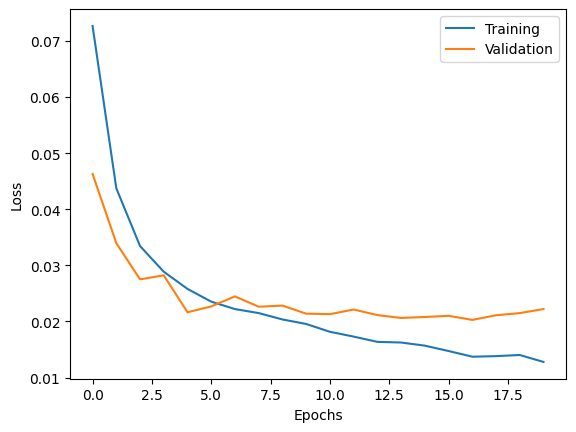

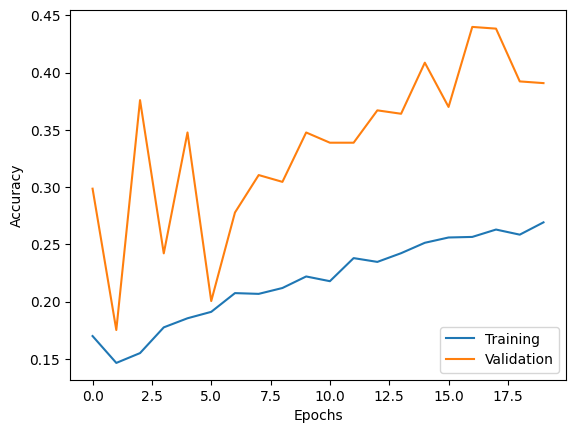

In [28]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(hist)

In [46]:
print('Number of Parameters',CNN.count_params())
print('Final Training Loss',hist.history['loss'][-1])
print('Final Validation Loss',hist.history['val_loss'][-1])

Number of Parameters 100364
Final Training Loss 0.012788894586265087
Final Validation Loss 0.02221544273197651


Python code that evaluates the results on a (separate) test set,

In [44]:
test_loss, test_metrics = CNN.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Metric: {test_metrics}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2111 - loss: 0.0278
Test Loss: 0.0274960994720459
Test Metric: 0.2065378874540329
